In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import TensorDataset, random_split, DataLoader
import torch.nn as nn
import time
import wandb
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import torch
from datetime import datetime
from sklearn.decomposition import PCA
from time import gmtime, strftime

now = datetime.now() # current date and time
date_time = now.strftime("%d-%m-%Y_%H:%M:%S")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device}.')

Using cuda.


In [2]:
def data_loading(data_path, label_path, batch_size, train_ratio=0.8):
    data = torch.load(data_path)
    labels = torch.load(label_path)
    data = nn.functional.normalize(data, dim=1)
    # reshaping the dataset so  the channels will be the second dimension.
    data = data.permute(0, 2, 1)
    print(data.size())
    
    def pca_reduction(data, n_components=4):
        data_reshaped = data.reshape(-1, data.shape[1])

        # Apply PCA
        pca = PCA(n_components=n_components)
        
        data_reduced = pca.fit_transform(data_reshaped)

        # Reshape back to (samples, n_components, time_steps)
        data_reduced = data_reduced.reshape(data.shape[0], n_components, data.shape[2])

        return data_reduced
    print(data.dtype)
    data = pca_reduction(data, n_components=4)
    data =(torch.from_numpy(data)).float()
    n_samples, n_channels, n_features = data.shape
    X_reshaped = data.reshape(n_samples, -1) 
    
    # Apply SMOTE
    smote = SMOTE(sampling_strategy='minority')
    data_resampled, labels_resampled = smote.fit_resample(X_reshaped, labels)
    print((labels_resampled==1).sum())
    # Reshape X_resampled back to 3D
    data_resampled = data_resampled.reshape(-1, n_channels, n_features)
    print(data_resampled.shape)
    data_resampled = torch.tensor(data_resampled)
    labels_resampled = torch.tensor(labels_resampled)
    dataset = TensorDataset(data_resampled, labels_resampled)
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    return DataLoader(train_dataset, batch_size=batch_size, shuffle=True), DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
data_path = 'NASA_data_50.pt'
label_path = 'NASA_label_50.pt'
data_loading(data_path=data_path, label_path=label_path,batch_size= 64)


torch.Size([848, 24, 50])
torch.float32
685
(1370, 4, 50)


(<torch.utils.data.dataloader.DataLoader at 0x7fd3b43d7be0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fd3b43d6470>)

In [3]:
# Define the CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self, dropout):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=5)
        self.bn1 = nn.BatchNorm1d(8)
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=5)
        self.bn2 = nn.BatchNorm1d(8)
        self.pool = nn.MaxPool1d(kernel_size=2, padding=0, stride=1)
        # the size of the out channels x number  of nodes 
        self.fc1 = nn.Linear(328, 200)
        self.fc2 = nn.Linear(200, 2)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x - self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        return x


In [4]:
def correct(logits, y):
    y_hat = logits.argmax(axis=1) # Finds the column with the highest value for each row of `logits`.
    return (y_hat == y).float().sum() # Computes the number of times that `y_hat` and `y` match.

In [5]:
def evaluate_metric(model, data_iter, metric):
    """Compute the average `metric` of the model on a dataset."""
    c = torch.tensor(0.).to(device)
    n = torch.tensor(0.).to(device)
    for X, y in data_iter:
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X)
        c += metric(logits, y)
        n += len(y)
    return c*100 / n

## Training

wandb: Currently logged in as: d-hadjikazemi (d-hadjikazemi-queen-mary-university-of-london). Use `wandb login --relogin` to force relogin


torch.Size([848, 24, 50])
torch.float32
685
(1370, 4, 50)

Epoch 1/100.
Training accuracy: 50.8211669921875. Testing accuracy: 46.715328216552734. Duration: 0.673s.

Epoch 2/100.
Training accuracy: 50.8211669921875. Testing accuracy: 46.715328216552734. Duration: 0.111s.

Epoch 3/100.
Training accuracy: 51.91605758666992. Testing accuracy: 47.445255279541016. Duration: 0.114s.

Epoch 4/100.
Training accuracy: 64.41606140136719. Testing accuracy: 57.29927062988281. Duration: 0.118s.

Epoch 5/100.
Training accuracy: 65.05474090576172. Testing accuracy: 58.759124755859375. Duration: 0.111s.

Epoch 6/100.
Training accuracy: 65.60218811035156. Testing accuracy: 59.8540153503418. Duration: 0.098s.

Epoch 7/100.
Training accuracy: 66.87956237792969. Testing accuracy: 63.13868713378906. Duration: 0.135s.

Epoch 8/100.
Training accuracy: 66.69708251953125. Testing accuracy: 59.124088287353516. Duration: 0.117s.

Epoch 9/100.
Training accuracy: 68.43065643310547. Testing accuracy: 62.04379653930

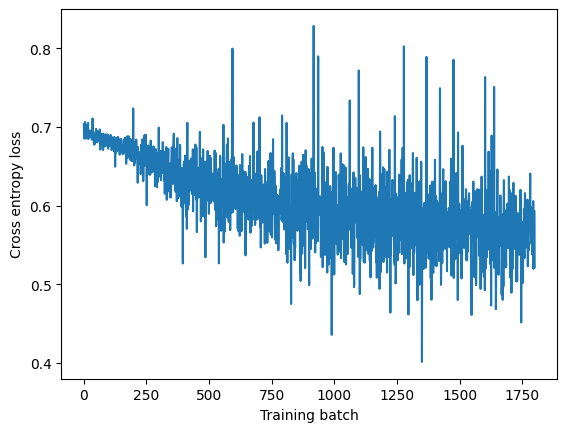

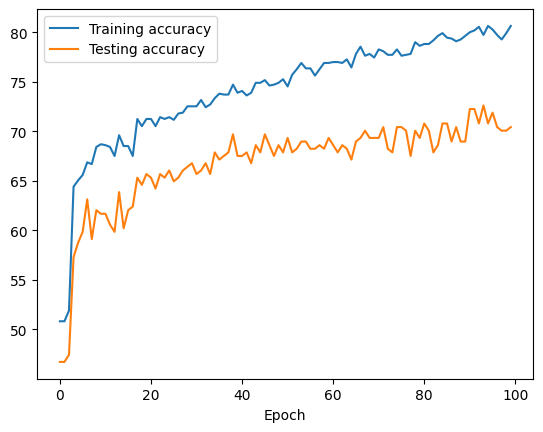

test_acc,▁▁▅▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇
train_acc,▁▁▄▅▅▅▅▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇█▇▇▇▇█████████
train_loss,▆▅▅▅▆▅▅▄▄▆▃▅▆▄▃▆▅▆▁▄█▂▃▆▇▅▄▆▁▂▃▇▇▅▂▇▂▄▁▂
test_acc,70.43796
train_acc,80.65694
train_loss,0.52174


In [6]:
wandb.init(
    # set the wandb project where this run will be logged
    project="NASA_turbo_fan",
    name= "feature reduction_{}".format(date_time),
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.0001,
    "architecture": "CNN",
    "epochs": 100,
    "loss": nn.BCELoss(),
    "batch_size": 64,
    "decay":1e-5,
    'dropout': 0.5
    }
)
config = wandb.config
data_path = 'NASA_data_50.pt'
label_path = 'NASA_label_50.pt'
train_loader, test_loader = data_loading(data_path=data_path, label_path=label_path,batch_size= config.batch_size)

losses = [] # Stores the loss for each training batch
train_accs = [] # Stores the training accuracy after each epoch
test_accs = [] # Stores the testing accuracy after each epoch

# Create an instance of the CNN
model = SimpleCNN(dropout=config.dropout)

# Loss and optimizer
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.decay)

model.to(device)

num_epochs = 100
for epoch in range(config.epochs):
    print(f'\nEpoch {epoch + 1}/{num_epochs}.')
    start_time = time.perf_counter()

    model.train() # This is necessary because batch normalization behaves differently between training and evaluation

    for X, y in train_loader:
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X) # Computes the logits for the batch of images `X`
        l = loss(logits, y) # Computes the loss given the `logits` and the class vector `y`
        optimizer.zero_grad() # Zeroes the gradients stored in the model parameters
        l.backward() # Computes the gradient of the loss `l` with respect to the model parameters

        optimizer.step() # Updates the model parameters based on the gradients stored inside them

        train_loss = float(l)
        losses.append(train_loss) # Stores the loss for this batch

    model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
    train_acc = evaluate_metric(model, train_loader, correct)
    train_accs.append(train_acc)
    test_acc = evaluate_metric(model, test_loader, correct)
    test_accs.append(test_acc)
    metrics = {"train_loss": train_loss,
               "train_acc": train_acc,
               "test_acc": test_acc}
    wandb.log(metrics)

    end_time = time.perf_counter()

    print(f'Training accuracy: {train_accs[-1]}. Testing accuracy: {test_accs[-1]}. Duration: {end_time - start_time:.3f}s.') # Computes and displays training/testing dataset accuracy.

plt.plot(losses) # Plots the loss for each training batch
plt.xlabel('Training batch')
plt.ylabel('Cross entropy loss')
plt.show()

plt.plot(list(map(lambda x: x.cpu(),train_accs)), label='Training accuracy')
plt.plot(list(map(lambda x: x.cpu(),test_accs)), label='Testing accuracy')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.show()
wandb.finish()

In [7]:
print('max test accuracy {}'.format(max(test_accs)))

max test accuracy 72.62773895263672
